# Курсовой проект Игнат Александра

## Задание для курсового проекта

Материалы к проекту (файлы):
train.csv
test.csv

Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

Целевая переменная:
Price

Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Требования к решению:
1. R2 > 0.6
2. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
3. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv 
Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).

Сроки сдачи:
Cдать проект нужно в течение 72 часов после окончания последнего вебинара. Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества. Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

Описание датасета:
Id - идентификационный номер квартиры
DistrictId - идентификационный номер района
Rooms - количество комнат
Square - площадь
LifeSquare - жилая площадь
KitchenSquare - площадь кухни
Floor - этаж
HouseFloor - количество этажей в доме
HouseYear - год постройки дома
Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
Social_1, Social_2, Social_3 - социальные показатели местности
Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
Price - цена квартиры

### Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### Пути к директориям и файлам

In [5]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'
PREDICTONS_PATH = './Ignat_predictions.csv'

### Загрузка данных

#### Тренировочные данные

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail(n=3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


#### Тестовые данные

In [7]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail(n=3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
4999,12504,30,2.0,60.555693,NaN,1.0,10,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B


#### Проверим соответствие размеров

In [8]:
train_df.shape[1]-1 == test_df.shape[1]

True

#### Объединенные данные

In [9]:
data = pd.concat([train_df, test_df], axis=0)
data = data.reset_index(drop=True)
data.shape

(15000, 20)

In [10]:
data.tail(n=3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
14997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B,NaN
14998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,NaN
14999,12504,30,2.0,60.555693,NaN,1.0,10,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,NaN


### Приведение типов

In [11]:
data.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [12]:
data.dtypes.value_counts()

int64      9
float64    8
object     3
dtype: int64

In [13]:
data['Id'] = data['Id'].astype(str)
data['DistrictId'] = data['DistrictId'].astype(str)

In [14]:
data.dtypes

Id                object
DistrictId        object
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

### Обзор данных

#### Целевая переменная

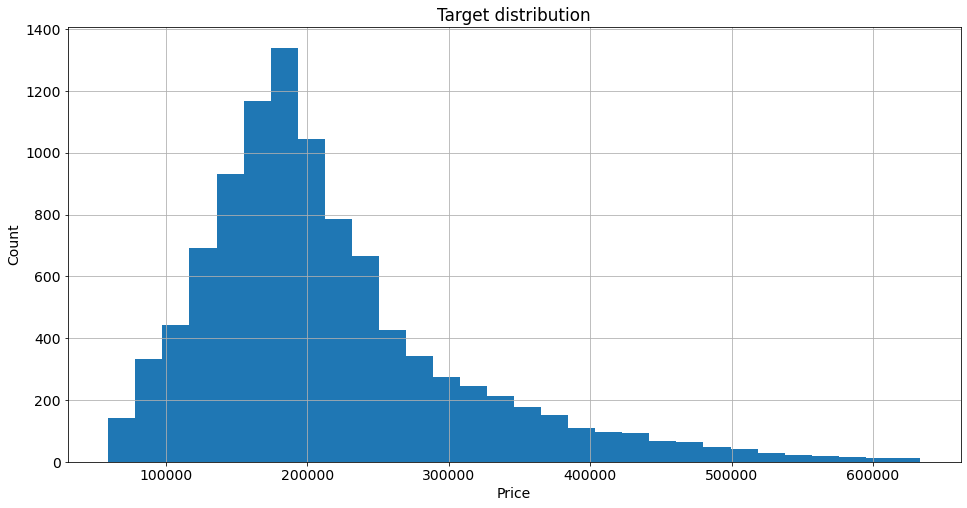

In [15]:
plt.figure(figsize = (16, 8))

data['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

#### Количественные переменные

In [16]:
data.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,15000.000000,15000.000000,11846.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,7825.000000,15000.000000,15000.000000,10000.000000
mean,1.897000,56.360350,36.851792,6.174467,8.561800,12.606600,3.321575e+03,0.119196,24.769267,5370.404933,8.113667,1144.162428,1.319467,4.235133,214138.857399
std,0.839229,20.423913,71.120183,24.016979,5.323113,6.780165,1.637078e+05,0.119371,17.532278,4013.364403,23.841946,1029.296278,1.489012,4.796545,92872.293865
min,0.000000,1.136859,0.333490,0.000000,1.000000,0.000000,1.908000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.814371,22.896130,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.645757,32.822810,6.000000,7.000000,12.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,66.036608,45.144624,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,78.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


#### Категориальные переменные

In [17]:
cat_colnames = data.select_dtypes(include='object').columns.tolist()
cat_colnames

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [18]:
for cat_colname in cat_colnames[2:]:
    print(str(cat_colname) + '\n\n' + str(data[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Ecology_2

B    14855
A      145
Name: Ecology_2, dtype: int64
****************************************************************************************************

Ecology_3

B    14576
A      424
Name: Ecology_3, dtype: int64
****************************************************************************************************

Shops_2

B    13763
A     1237
Name: Shops_2, dtype: int64
****************************************************************************************************



### Обработка выбросов

#### Rooms

In [19]:
data['Rooms'].value_counts()

2.0     5910
1.0     5474
3.0     3334
4.0      240
5.0       25
0.0       10
6.0        3
10.0       2
19.0       1
17.0       1
Name: Rooms, dtype: int64

In [20]:
data.loc[data['Rooms'].isin([0, 6, 10, 17, 19]), 'Rooms'] = data['Rooms'].median()

#### Square, LifeSquare, KitchenSquare

In [21]:
data.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,15000.000000,15000.000000,11846.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,7825.000000,15000.000000,15000.000000,10000.000000
mean,1.894333,56.360350,36.851792,6.174467,8.561800,12.606600,3.321575e+03,0.119196,24.769267,5370.404933,8.113667,1144.162428,1.319467,4.235133,214138.857399
std,0.809369,20.423913,71.120183,24.016979,5.323113,6.780165,1.637078e+05,0.119371,17.532278,4013.364403,23.841946,1029.296278,1.489012,4.796545,92872.293865
min,1.000000,1.136859,0.333490,0.000000,1.000000,0.000000,1.908000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.814371,22.896130,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.645757,32.822810,6.000000,7.000000,12.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,66.036608,45.144624,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,5.000000,641.065193,7480.592129,2014.000000,78.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [22]:
data["LifeSquare"].isnull().sum()

3154

In [23]:
data.loc[data['LifeSquare'] < 10, 'LifeSquare'] = 10

In [24]:
data.loc[data['KitchenSquare'] < 3, 'KitchenSquare'] = 3

#### HouseFloor, Floor

In [25]:
data['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,
        99., 117.])

In [26]:
data['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 37, 38,
       42, 46, 78], dtype=int64)

In [27]:
data.loc[data['HouseFloor'] == 0, 'HouseFloor'] = data['HouseFloor'].median()

In [28]:
floor_outliers = data[data['Floor'] > data['HouseFloor']].index

data.loc[floor_outliers, 'Floor'] = data.loc[floor_outliers, 'HouseFloor'].apply(
    lambda x: random.randint(1, x)
)

In [29]:
data.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,15000.000000,15000.000000,11846.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,7825.000000,15000.000000,15000.000000,10000.000000
mean,1.894333,56.360350,37.025597,6.868200,7.426467,12.926600,3.321575e+03,0.119196,24.769267,5370.404933,8.113667,1144.162428,1.319467,4.235133,214138.857399
std,0.809369,20.423913,71.045828,23.881704,5.067811,6.452885,1.637078e+05,0.119371,17.532278,4013.364403,23.841946,1029.296278,1.489012,4.796545,92872.293865
min,1.000000,1.136859,10.000000,3.000000,1.000000,1.000000,1.908000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.814371,22.896130,3.000000,3.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.645757,32.822810,6.000000,6.000000,12.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,66.036608,45.144624,9.000000,10.000000,17.000000,2.001000e+03,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,5.000000,641.065193,7480.592129,2014.000000,46.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


#### HouseYear

In [30]:
data['HouseYear'].sort_values(ascending=False)

1497     20052011
4189         4968
4376         2020
14389        2020
790          2020
           ...   
10064        1911
12691        1910
9317         1910
10002        1909
13253        1908
Name: HouseYear, Length: 15000, dtype: int64

In [31]:
data.loc[data['HouseYear'] > 2020, 'HouseYear'] = 2020

### Обработка пропусков

In [32]:
len(data) - data.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       3154
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     7175
Helthcare_2         0
Shops_1             0
Shops_2             0
Price            5000
dtype: int64

#### LifeSquare

In [33]:
data['LifeSquare'].median()

32.82280955016516

In [34]:
square_med_diff = (data.loc[data['LifeSquare'].notnull(), 'Square'] -\
                   data.loc[data['LifeSquare'].notnull(), 'LifeSquare'] -\
                   data.loc[data['LifeSquare'].notnull(), 'KitchenSquare']).median()

square_med_diff

11.369301596639595

In [35]:
data.loc[data['LifeSquare'].isnull(), 'LifeSquare'] =\
data.loc[data['LifeSquare'].isnull(), 'Square'] -\
data.loc[data['LifeSquare'].isnull(), 'KitchenSquare'] -\
square_med_diff

In [36]:
data['LifeSquare'].median()

33.86276212516104

#### Healthcare_1

In [37]:
data['Healthcare_1'].value_counts()

540.0     768
30.0      511
1046.0    365
750.0     235
2300.0    220
         ... 
920.0      19
1815.0     19
32.0       19
35.0        4
0.0         2
Name: Healthcare_1, Length: 79, dtype: int64

In [38]:
data.loc[data['Healthcare_1'].isnull(), 'Healthcare_1'] = data['Healthcare_1'].median()

### Построение новых признаков

#### Dummies

In [39]:
data["Ecology_2"].value_counts()

B    14855
A      145
Name: Ecology_2, dtype: int64

In [40]:
data["Ecology_3"].value_counts()

B    14576
A      424
Name: Ecology_3, dtype: int64

In [41]:
data["Shops_2"].value_counts()

B    13763
A     1237
Name: Shops_2, dtype: int64

In [42]:
data['Ecology_2_bin'] = data['Ecology_2'].replace({'A':0, 'B':1})
data['Ecology_3_bin'] = data['Ecology_3'].replace({'A':0, 'B':1})
data['Shops_2_bin'] = data['Shops_2'].replace({'A':0, 'B':1})

#### DistrictSize, IsDistrictLarge

In [43]:
district_size = data['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,1242
1,1,996
2,23,829
3,6,768
4,9,426


In [44]:
data = data.merge(district_size, on='DistrictId', how='left')
data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,5,900.0,0,11,B,184966.930730,1,1,1,36
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,240.0,1,16,B,300009.450063,1,1,1,131
2,4765,53,2.0,44.947953,29.197612,3.0,8,12.0,1968,0.049637,...,0,229.0,1,3,B,220925.908524,1,1,1,265
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,3,1084.0,0,5,B,175616.227217,1,1,1,270
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,1,2078.0,2,4,B,150226.531644,1,1,1,139


### Отбор признаков

In [45]:
data.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'DistrictSize']

In [46]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin']
new_feature_names = ['DistrictSize']
target_name = 'Price'

In [47]:
data.shape

(15000, 24)

### Разбиение на train и test

In [48]:
train = data[data["Price"].notnull()]
test = data[data["Price"].isnull()]

In [49]:
X = train[feature_names + new_feature_names]
y = train[target_name]

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

### Построение модели

In [51]:
X_train.isnull().sum()

Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2_bin    0
Ecology_3_bin    0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2_bin      0
DistrictSize     0
dtype: int64

In [52]:
rf_model = RandomForestRegressor(max_depth=8, n_estimators=100, random_state=21)
rf_model.fit(X_train.fillna(-9999), y_train)

RandomForestRegressor(max_depth=8, random_state=21)

In [53]:
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=21, verbose=0, warm_start=False)

RandomForestRegressor(max_depth=8, random_state=21)

Train R2:	0.814
Test R2:	0.706


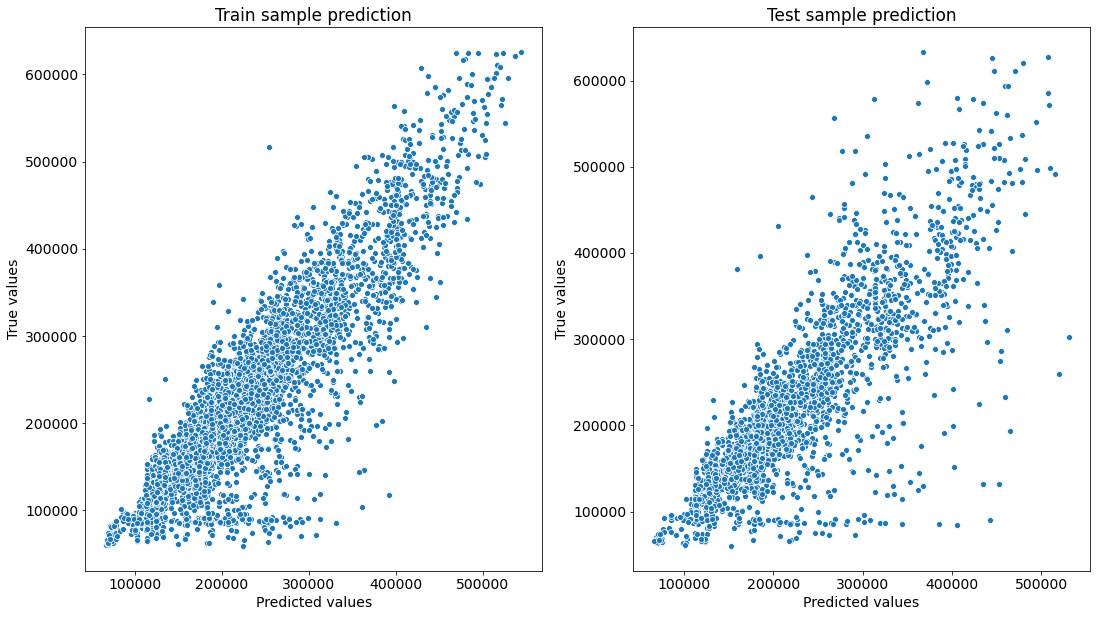

In [54]:
y_train_preds = rf_model.predict(X_train.fillna(-9999))
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

### Перекрёстная проверка

In [55]:
from sklearn.model_selection import StratifiedKFold

In [56]:
cv_score = cross_val_score(
    rf_model,
    X.fillna(-9999),
    y,
    scoring='r2',
    cv=KFold(n_splits=5, shuffle=True, random_state=1)
)
cv_score

array([0.70908077, 0.71821681, 0.70629464, 0.74358112, 0.70308335])

In [57]:
cv_score.mean(), cv_score.std()

(0.7160513386588019, 0.014659663173471482)

In [58]:
cv_score.mean() - cv_score.std(), cv_score.mean() + cv_score.std()

(0.7013916754853304, 0.7307110018322733)

In [59]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.524055
17,DistrictSize,0.272384
12,Social_3,0.045470
7,Ecology_1,0.023297
11,Social_2,0.020370
10,Social_1,0.017455
6,HouseYear,0.017326
2,LifeSquare,0.015272
3,KitchenSquare,0.013338
5,HouseFloor,0.013110


### Прогноз

In [60]:
X_result = test[feature_names + new_feature_names]
y_result = rf_model.predict(X_result)

In [61]:
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
10000,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,1,900.0,0,0,B,NaN,1,1,1,270
10001,15856,74,2.0,69.263183,54.893882,3.0,1,1.0,1977,0.075779,...,3,900.0,0,2,B,NaN,1,1,1,175
10002,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,...,87,4702.0,5,5,B,NaN,1,1,1,9
10003,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,3,900.0,3,3,B,NaN,1,1,1,146
10004,14275,27,1.0,47.527111,43.387569,3.0,17,17.0,2017,0.072158,...,1,900.0,0,0,A,NaN,1,1,0,1242


In [62]:
result = test
result

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
10000,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,1,900.0,0,0,B,NaN,1,1,1,270
10001,15856,74,2.0,69.263183,54.893882,3.0,1,1.0,1977,0.075779,...,3,900.0,0,2,B,NaN,1,1,1,175
10002,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,...,87,4702.0,5,5,B,NaN,1,1,1,9
10003,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,3,900.0,3,3,B,NaN,1,1,1,146
10004,14275,27,1.0,47.527111,43.387569,3.0,17,17.0,2017,0.072158,...,1,900.0,0,0,A,NaN,1,1,0,1242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,...,0,900.0,1,1,B,NaN,1,1,1,174
14996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,...,0,900.0,0,1,B,NaN,1,1,1,996
14997,5783,12,3.0,77.842178,48.282625,9.0,15,22.0,1989,0.090799,...,2,900.0,5,15,B,NaN,1,1,1,100
14998,4780,62,2.0,81.305222,66.935920,3.0,4,12.0,1977,0.072158,...,1,900.0,0,0,A,NaN,1,1,0,369


In [63]:
result["Price"] = y_result
result.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
10000,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,1,900.0,0,0,B,149684.040827,1,1,1,270
10001,15856,74,2.0,69.263183,54.893882,3.0,1,1.0,1977,0.075779,...,3,900.0,0,2,B,209531.867668,1,1,1,175
10002,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,...,87,4702.0,5,5,B,247075.709485,1,1,1,9
10003,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,3,900.0,3,3,B,338285.633567,1,1,1,146
10004,14275,27,1.0,47.527111,43.387569,3.0,17,17.0,2017,0.072158,...,1,900.0,0,0,A,130212.699504,1,1,0,1242


In [64]:
output = result[["Id","Price"]]
output

,Id,Price
10000,725,149684.040827
10001,15856,209531.867668
10002,5480,247075.709485
10003,15664,338285.633567
10004,14275,130212.699504
...,...,...
14995,8180,246716.924268
14996,4695,136639.631114
14997,5783,326704.098349
14998,4780,197147.470062


In [65]:
output.to_csv(PREDICTONS_PATH, index=False, encoding='utf-8')